In [1]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.stats import linregress

## Define arm model(look at writeup for details)

In [2]:
def calculate_angles(P, alpha, x, y, theta_1):
    u = np.array([1, 0])
    v = np.array([0, 1])
    R = P + np.array([alpha * np.cos(np.radians(180) - theta_1), alpha * np.sin(np.radians(180) - theta_1)])
    if(max(x, y, norm(R)) > sum([x, y, norm(R)]) - max(x, y, norm(R))):
        #print("not a triangle!")
        return None, None
    if(abs((norm(R) ** 2 + x ** 2 - y ** 2) / (2 * x * norm(R))) > 1):
        print("invalid theta for", x, y, norm(R))
        
    qor = np.arccos((norm(R) ** 2 + x ** 2 - y ** 2) / (2 * x * norm(R)))
    oqr = np.arccos((x ** 2 + y ** 2  - norm(R) ** 2)/(2 * x * y))
    
    
    theta_R = np.arccos(np.dot(R, u)/norm(R))
    theta_R = 2 * np.pi - theta_R if np.dot(R, v) < 0 else theta_R


    rotation_matrix = np.array([[np.cos(np.pi/2), -np.sin(np.pi/2)],
                                [np.sin(np.pi/2), np.cos(np.pi/2)]])
    

    if np.dot(np.array([x * np.cos(theta_R - qor), x * np.sin(theta_R - qor)]), rotation_matrix @ R) > 0:
        theta_2 = theta_R - qor
    elif np.dot(np.array([x * np.cos(theta_R + qor), x * np.sin(theta_R + qor)]), rotation_matrix @ R) > 0: 
        theta_2 = theta_R + qor
    else:
        return None, None
    
    Q = np.array([x * np.cos(theta_2), y * np.sin(theta_2)])

    return np.pi - theta_2, oqr

## Define measured locations

In [3]:
P = np.array([25.5, 9])

## 1. Gridsearch $x, y, \alpha$

### Define length bounds
$x_{min} <= x <= x_{max}$

$y_{min} <= y <= y_{max}$

$-\theta_{limit} <= \theta_1 <= \theta_{limit}$

In [4]:
xmin = 3
xmax = 14
ymin = 3
ymax = 14
alpha_min = 30
alpha_max = 35
theta_limit = np.deg2rad(10)

In [5]:
x_grid = list(np.linspace(xmin, xmax, 20))  # too lazy to vectorize the simulation
y_grid = list(np.linspace(ymin, ymax, 20))
alpha_grid = list(np.linspace(alpha_min, alpha_max, 10))
combinations = list(itertools.product(x_grid, y_grid, alpha_grid))
len(combinations)

4000

### Perform grid search

In [6]:
result_df = pd.DataFrame({"x": [i[0] for i in combinations], "y": [i[1] for i in combinations], "alpha": [i[2] for i in combinations]})
# below are result columns
result_df.head()

,x,y,alpha
0,3.0,3.0,30.000000
1,3.0,3.0,30.555556
2,3.0,3.0,31.111111
3,3.0,3.0,31.666667
4,3.0,3.0,32.222222


In [7]:
%%time
theta2_mins = []
theta2_maxs = []
oqr_mins = []
oqr_maxs = []
fit_errors = []
reg_a = []
reg_b = []
theta2_at_theta1_0 = []
oqr_at_theta1_0 = []
for index, row in result_df.iterrows():
    x = row["x"]
    y = row["y"]
    alpha = row["alpha"]
    theta2_min = float("inf")
    theta2_max = float("-inf")
    oqr_min = float("inf")
    oqr_max = float("-inf")
    theta2_prev = 0
    calculated_theta2s = []
    thetas = list(np.linspace(-theta_limit, theta_limit))
    for index, theta_1 in enumerate(thetas):  # almost same performance as np.vectorize
        theta2, oqr = calculate_angles(P, alpha, x, y, theta_1)
        if not theta2 or not oqr:
            theta2_min = np.nan
            theta2_max = np.nan
            oqr_min = np.nan
            oqr_max = np.nan
            break
        calculated_theta2s.append(np.rad2deg(theta2))
        oqr_min = min(oqr_min, oqr)
        oqr_max = max(oqr_max, oqr)
        theta2_min = min(theta2_min, theta2)
        theta2_max = max(theta2_max, theta2)
    if np.isnan(theta2_min):
        theta2_mins.append(theta2_min)
        theta2_maxs.append(theta2_max)
        oqr_mins.append(oqr_min)
        oqr_maxs.append(oqr_max)
        fit_errors.append(np.nan)
        reg_a.append(np.nan)
        reg_b.append(np.nan)
        theta2_at_theta1_0.append(np.nan)
        oqr_at_theta1_0.append(np.nan)
    else:
        theta1_arr = np.rad2deg(np.array(thetas))
        theta2_arr = np.array(calculated_theta2s)
        regression = linregress(theta1_arr, theta2_arr)
        slope = regression.slope
        intercept = regression.intercept
        fit = theta1_arr * slope + intercept
        mae = np.sum(np.abs(fit - theta2_arr))/fit.shape
        fit_errors.append(mae[0])
        reg_a.append(intercept)
        reg_b.append(slope)
        theta2_mins.append(np.rad2deg(theta2_min))
        theta2_maxs.append(np.rad2deg(theta2_max))
        oqr_mins.append(np.rad2deg(oqr_min))
        oqr_maxs.append(np.rad2deg(oqr_max))
        t0, o0  = calculate_angles(P, alpha, x, y, 0)
        theta2_at_theta1_0.append(np.rad2deg(t0))
        oqr_at_theta1_0.append(np.rad2deg(o0))
        

        
result_df["theta2_min"] = theta2_mins
result_df["theta2_max"] = theta2_maxs
result_df["theta2@0"] = theta2_at_theta1_0
result_df["oqr@0"] = oqr_at_theta1_0
result_df["oqr_min"] = oqr_mins
result_df["oqr_max"] = oqr_maxs
result_df["fit_error"] = fit_errors
result_df["reg_a"] = reg_a
result_df["reg_b"] = reg_b
result_df = result_df.copy()

CPU times: user 10.1 s, sys: 24 ms, total: 10.1 s
Wall time: 10.1 s


In [8]:
result_df = result_df.loc[np.logical_not(np.isnan(result_df["theta2_min"]))]
result_df

,x,y,alpha,theta2_min,theta2_max,theta2@0,oqr@0,oqr_min,oqr_max,fit_error,reg_a,reg_b
589,4.157895,13.421053,35.000000,-142.295123,52.691906,-42.114003,76.442610,13.674849,171.406817,3.130819,-44.002640,8.582389
731,4.736842,10.526316,30.555556,-125.083287,57.029369,-18.602773,74.480595,8.929829,158.057094,4.452412,-22.764494,7.844620
743,4.736842,11.105263,31.666667,-121.262323,52.347191,-24.311005,75.277781,15.903772,156.908079,3.472892,-27.631617,7.770972
754,4.736842,11.684211,32.222222,-132.428586,43.286076,-30.225156,72.779676,11.369827,147.073377,3.955334,-34.298894,7.875778
755,4.736842,11.684211,32.777778,-117.118101,49.750649,-28.513346,76.951122,22.793193,158.311723,2.571934,-30.757943,7.629603
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,14.000000,14.000000,32.777778,-48.360009,10.529850,-14.543725,48.833466,31.259987,70.603411,1.164733,-16.009906,2.881913
3996,14.000000,14.000000,33.333333,-49.728537,9.759721,-15.813413,50.443865,33.202839,72.232142,1.113399,-17.223506,2.918692
3997,14.000000,14.000000,33.888889,-50.811137,9.091164,-16.921196,52.132085,35.206626,73.940075,1.053163,-18.262362,2.945968
3998,14.000000,14.000000,34.444444,-51.645995,8.522329,-17.875503,53.894222,37.264900,75.726588,0.987725,-19.138904,2.965385


### condition 1: min, max angle of $\theta_2$

$-60° <= \theta_2 <= 60°$

-55 is the lowest the lower arm can go before hitting the backplate. 50 seems like a reasonable max angle

In [19]:
cond1 = result_df.loc[np.logical_and(result_df["theta2_min"] >= -30, result_df["theta2_max"] <= 50)]
cond1.sort_values(by=['fit_error']).loc[cond1["fit_error"] > 0.8 ]

,x,y,alpha,theta2_min,theta2_max,theta2@0,oqr@0,oqr_min,oqr_max,fit_error,reg_a,reg_b
3456,12.842105,5.894737,33.333333,4.578666,45.386033,21.752296,67.758812,26.352028,118.701127,0.816745,22.756723,2.032797
3500,12.842105,8.789474,30.000000,9.407113,37.842780,20.403110,51.372955,20.502900,83.920120,0.817360,21.387835,1.475208
3701,13.421053,8.789474,30.555556,9.263897,36.775640,19.773884,50.262852,19.311957,82.292970,0.820626,20.756458,1.433868
3350,12.263158,11.684211,30.000000,-27.708175,23.951350,1.238651,49.620033,26.625286,76.141322,0.820747,0.256797,2.508931
3902,14.000000,8.789474,31.111111,9.164090,35.797707,19.194866,49.212291,18.114006,80.782390,0.827989,20.179808,1.395033
...,...,...,...,...,...,...,...,...,...,...,...,...
3060,11.684211,6.473684,30.000000,23.508945,49.106144,29.838877,59.324424,12.480041,105.267072,2.138100,32.273829,1.260528
3891,14.000000,8.210526,30.555556,21.083081,39.585186,25.120228,46.977414,5.877966,80.568361,2.237965,27.525525,0.821642
3681,13.421053,7.631579,30.555556,21.676716,41.744120,26.208857,49.951246,6.227295,86.466295,2.251697,28.644253,0.915486
3471,12.842105,7.052632,30.555556,22.305550,44.267840,27.431079,53.360707,6.622687,93.506983,2.278226,29.915022,1.024876


### condition2 : min, max angle of OQR

In [10]:
cond2 = cond1.loc[np.logical_and(result_df["oqr_min"] >= 42, result_df["oqr_max"] <= 100)]
cond2.sort_values(by=['fit_error'])

,x,y,alpha,theta2_min,theta2_max,theta2@0,oqr@0,oqr_min,oqr_max,fit_error,reg_a,reg_b
3919,14.000000,9.368421,35.0,-23.648402,27.129965,3.158980,64.599793,42.046044,95.249316,0.390938,2.687166,2.497055
3719,13.421053,9.368421,35.0,-26.211427,27.435028,2.081796,67.399029,44.642075,99.123729,0.408877,1.586509,2.637727
3929,14.000000,9.947368,35.0,-27.175910,24.754803,0.525457,63.632713,42.308067,92.637394,0.472590,-0.056667,2.555037
3729,13.421053,9.947368,35.0,-29.728940,24.941095,-0.607446,66.182446,44.603633,96.168702,0.489126,-1.212205,2.690023


## optimal values:

\# 3127

$\alpha = 33.8$

$x = 11.6842$

$y = 9.9474$

## 2. Verify optimal values are valid

In [30]:
target_row = 3127
alpha, x, y, reg_a, reg_b, fit_error = result_df.loc[target_row, "alpha"],result_df.loc[target_row, "x"], result_df.loc[target_row, "y"], result_df.loc[target_row, "reg_a"], result_df.loc[target_row, "reg_b"], result_df.loc[target_row, "fit_error"]
print(f"alpha:{alpha:.4f}, x:{x:.4f}, y:{y:.4f}, reg_a:{reg_a:.4f}, reg_b:{reg_b:.4f}, error:{fit_error:.4f}")

alpha:33.8889, x:11.6842, y:9.9474, reg_a:-2.6297, reg_b:3.0281, error:0.5906


<IPython.core.display.Javascript object>


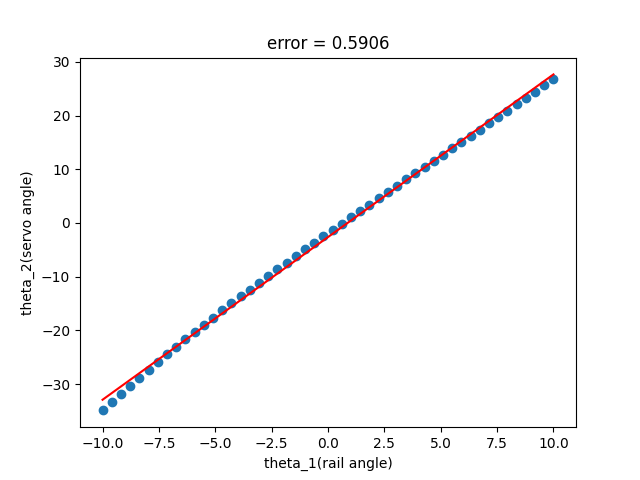

<IPython.core.display.Javascript object>


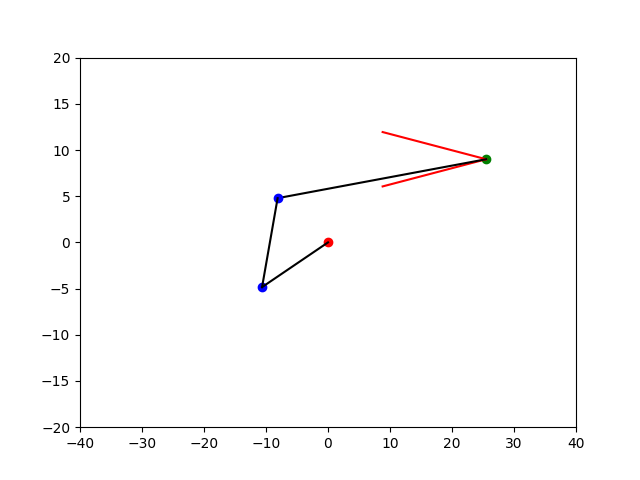

In [31]:
%matplotlib notebook

def plot_2_points(a, b, ax, color="k"):
    xvals = [a[0], b[0]]
    yvals = [a[1], b[1]]
    ax.plot(xvals, yvals, f"{color}-")

f1, a1 = plt.subplots()
a1.set_xlabel("theta_1(rail angle)")
a1.set_ylabel("theta_2(servo angle)")
a1.set_title(f"error = {fit_error:.4f}")
fig, ax = plt.subplots()
ax.set_xlim([-40, 40])
ax.set_ylim([-20, 20])

n_thetas = 50
max_theta1_angle = np.deg2rad(10)
thetas = np.linspace(-max_theta1_angle, max_theta1_angle, n_thetas)


theta_2s = []
for i in list(thetas):
    theta_2s.append(np.rad2deg(calculate_angles(P, alpha, x, y, i)[0]))
a1.scatter(np.rad2deg(thetas), theta_2s)
plot_2_points((np.rad2deg(thetas[0]), np.rad2deg(thetas[0]) * reg_b + reg_a), (np.rad2deg(thetas[-1]), np.rad2deg(thetas[-1]) * reg_b + reg_a), a1, "r")

#print((np.rad2deg(thetas[0]), theta_2s[0]), (np.rad2deg(thetas[-1]), theta_2s[-1]))

last_successful_i = 0

def update_simulation(i):
    ax.clear()
    ax.set_xlim([-40, 40])
    ax.set_ylim([-20, 20])
    origin = np.array([0, 0])
    ax.plot(*origin, "ro", label="O")
    ax.plot(*P, "go", label="O")
    #plot_2_points(origin, P, ax)
    plot_2_points(P, P + np.array([alpha/2 * np.cos(np.radians(180) + max_theta1_angle), alpha/2 * np.sin(np.radians(180) + max_theta1_angle)]), ax, "r")
    plot_2_points(P, P + np.array([alpha/2 * np.cos(np.radians(180) - max_theta1_angle), alpha/2 * np.sin(np.radians(180) - max_theta1_angle)]), ax, "r")
    
    theta2, oqr = calculate_angles(P, alpha, x, y, thetas[i])
    
    if not theta2:
        theta2, oqr = calculate_angles(P, alpha, x, y, thetas[last_successful_i])
        R = P + np.array([alpha * np.cos(np.radians(180) - thetas[last_successful_i]), alpha * np.sin(np.radians(180) - thetas[last_successful_i])])
    else:
        theta_2s.append(theta2)
        last_successful_i = i
        R = P + np.array([alpha * np.cos(np.radians(180) - thetas[i]), alpha * np.sin(np.radians(180) - thetas[i])])
        
    plot_2_points(P, R, ax)
    ax.plot(*R, "bo", label="O")
    
    Q = origin + np.array([x * np.cos(-theta2 - np.pi), x * np.sin(- theta2 - np.pi)])
    ax.plot(*Q, "bo", label="O")
    plot_2_points(origin, Q, ax)
    
    plot_2_points(Q, R, ax)


anim = animation.FuncAnimation(fig, update_simulation, frames=n_thetas, interval=50)

#writer = animation.writers['ffmpeg']
anim.save("test3.mp4", writer="ffmpeg")

In [13]:
(-34.59716092064957 - 30.80903081285573)/(-10.0 - 10.0)

3.270309586675265